# Using Multiple Variables
According to [the documentation](https://myololobuckert213913653.s3.amazonaws.com/documentation/bangladesh-tropical-cyclone-historical-catalogue/HistoricalCatalogueDataDescription.pdf?) the filenames indicate the varibles which they model. Each file contains one variable, along with its dimensions. For example, FB is wind speed of gust. Here, I will extract multiple variables from the same time period (again see documentation) then do funkey stuff. \
Note this will require all 1991 data in the `data/1991TS` folder, although the outputs will still be available in the notebook

In [2]:
import netCDF4 as nc
from rich import print
import pandas as pd
from scipy import stats

import imageio
import os

PATH = "../data/1991TS"
# WIND SPEED OF GUST
FG = "fg.T1Hmax.UMRA2T.19910428_19910501.BOB01.4p4km.nc"
# RAINFALL
PRLST = "prlst.T1Hmean.UMRA2T.19910428_19910501.BOB01.4p4km.nc"

prlst = nc.Dataset(f"{PATH}/{PRLST}")
fg = nc.Dataset(f"{PATH}/{FG}")


# print(prlst.variables.values())

## Now we are gonna load the requisite data
Note that the lat and long should be the same, I may bother checking, lets find out!

In [3]:
# I checked the dimensions!
assert prlst.variables["latitude"][:].shape == fg.variables["latitude"][:].shape
assert prlst.variables["longitude"][:].shape == fg.variables["longitude"][:].shape


# COLUMNNS

latitude = fg.variables["latitude"][:]
longitude = fg.variables["longitude"][:]
wind_speed = fg.variables["wind_speed_of_gust"][:][0]
rainfall = prlst.variables["stratiform_rainfall_amount"][0]



## Visualise

I want to visualise both side-by-side to see how they affect eachother. \
Then I will see if I can communicate them both at the same time on the same visualisation

What follows is a **function** that produces a gif out of a dependent variable. A dependent variable is one that changes over time, such as `wind_speed` \
Pass in to the function: the output filename, the longitude matrix (ex: `longitude`), the latitude matrix (ex: `longitude`), and the dependent variable matrix (ex: `wind_speed`)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def visualise(output_filename: str, long: np.ndarray, lat: np.ndarray, variable: np.ndarray):
    """
    just a bog standard visualisation function for putting a time series variable on a long vs lat graph
    variable should be a time series of frames
    """
    filenames = []
    maxlevel = variable.max()
    minlevel = variable.min()
    steps = 7
    levels = [((maxlevel - minlevel)/steps) * val for val in list(range(steps))]
    
    for idx, frame in enumerate(variable):
        fig, ax = plt.subplots()
        cntr = ax.contourf(long, lat, frame, levels=levels)
        fig.colorbar(cntr, ax=ax)
        filename = f"vis/sc{idx}.png"
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
        
    # build gif
    with imageio.get_writer(f"vis/{output_filename}", mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)
        

visualise("wind_speed.gif", longitude, latitude, wind_speed)
visualise("rainfall.gif", longitude, latitude, rainfall)

## Here we go boys

![Windspeed](./vis/wind_speed.gif)
![Rainfall](./vis/rainfall.gif)

In [6]:
VA = "va.T1Hpoint.UMRA2T.19910428_19910501.BOB01.4p4km.nc"
UA = "ua.T1Hpoint.UMRA2T.19910428_19910501.BOB01.4p4km.nc"
va = nc.Dataset(f"{PATH}/{VA}")
ua = nc.Dataset(f"{PATH}/{UA}")

assert ua.variables["latitude"][:].shape == va.variables["latitude"][:].shape
assert ua.variables["longitude"][:].shape == va.variables["longitude"][:].shape


# COLUMNNS

latitude = ua.variables["latitude"][:]
longitude = ua.variables["longitude"][:]
x_wind = ua.variables["x_wind"][:][0]
y_wind = va.variables["y_wind"][:][0]

visualise("x_wind.gif", longitude, latitude, x_wind)
visualise("y_wind.gif", longitude, latitude, y_wind)

## X wind and Y wind speeds
![Windspeed](./vis/x_wind.gif)
![Rainfall](./vis/y_wind.gif)

Interesting how there are white values and purple values, are white values 0 or nonexistent

In [7]:
ydf = pd.DataFrame(y_wind[0].flatten())
ydf.describe()

,0
count,640710.000000
mean,0.396193
std,4.652210
min,-39.125000
25%,-2.375000
50%,0.000000
75%,2.625000
max,44.625000


In [8]:
ydf[ydf == 0].describe()

,0
count,7994.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [9]:
ydf.notna().describe()

,0
count,640710
unique,1
top,True
freq,640710


Definitely not NaN values, and I don't think they are 0's either, as 0 only comprises around 1% of the total values, and there are mad white spaces in the visualisations

## Correlation 
I believe x_wind and y_wind will be correlated as they have a common causality \
And indeed they do, flattened arrays have corresponding values at each index, and we cannot have a 2d input to the `cov` function. There is a positive correlation between the two variables of `2.65`

In [10]:
flattened = [x_wind.flatten(), y_wind.flatten()]
np.cov(flattened)

array([[18.91917784,  2.64766503],
       [ 2.64766503, 22.95169916]])

**Pearson's correlation** indicates that the positive relationship between the two is insignificant, because `-0.5 < X < 0.5` \
This, however could be due to the nonlinearity of the correlation between the two. Around the areas away from the cyclone centre, the wind is random.

In [11]:
np.corrcoef(flattened)

array([[1.        , 0.12705872],
       [0.12705872, 1.        ]])

**Spearman's correlation** helps us model nonlinear relationships

In [12]:
stats.spearmanr(flattened, axis=1)

SpearmanrResult(correlation=0.17057875031756628, pvalue=0.0)

In [13]:
stats.spearmanr(flattened[0], flattened[1])

SpearmanrResult(correlation=0.17057875031756628, pvalue=0.0)

## B-tech graph

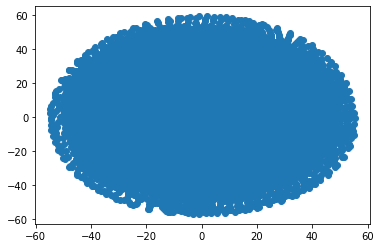

In [14]:
plt.scatter(flattened[0], flattened[1])
plt.show()